In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import sys,os
import glob
import crflux.models as mods
import gsf
from methods import *
import scipy.stats
import joblib
from tensorflow.keras.models import load_model
from functools import partial
from scipy.optimize import curve_fit
import matplotlib
from scipy.stats import chisquare

In [2]:
Energy = np.linspace(10**6.5,10**8,10000)

In [3]:
corsika_id = [14,402,1608,5426]

In [4]:
data = pd.read_csv('files/data.csv')
data = new_df_data(data)

/home/andy/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
def xmax_model(df):
    inputs = ['cos_zenith','S125','log_energy_loss','he_stoch','he_stoch2','m_r','m_o','m_125','s_mean','s_std','A']
    files = np.sort(np.array(glob.glob('files/model_coinc_best_*.h5')))
    correction = np.sort(np.array(glob.glob('files/Xmax_bias_correction*')))
    prediction = []
    for i in range(len(files)):
        model = load_model(files[i]) 
        bias = joblib.load(correction[i])
        xmax = model.predict(df[inputs])[:,1]
        bias_value = bias.predict(xmax.reshape(-1,1))
        xmax_predictions = np.array([(i-j) for i,j in zip(xmax,bias_value)])
        prediction.append(xmax_predictions)
    output = np.array([np.mean(i) for i in list(zip(*prediction))])
    return output

In [6]:
xmax_data = xmax_model(data)

In [7]:
def mass_model(df):
    inputs = ['cos_zenith','S125','log_energy_loss','he_stoch','he_stoch2','m_r','m_o','m_125','s_mean','s_std','A']
    files = np.sort(np.array(glob.glob('files/mass_model*')))
    prediction = []
    for i in range(len(files)):
        model = joblib.load(files[i]) 
        mass = model.predict(df[inputs])
        prediction.append(mass)
    output = np.array([np.mean(i) for i in list(zip(*prediction))])
    return output

In [8]:
mass_data = mass_model(data)

In [9]:
def Energy_model(df):
    inputs = ['cos_zenith','S125','log_energy_loss','he_stoch','he_stoch2','m_r','m_o','m_125','s_mean','s_std','A']
    files = np.sort(np.array(glob.glob('files/Energy_model*')))
    prediction = []
    for i in range(len(files)):
        model = joblib.load(files[i]) 
        mass = model.predict(df[inputs])
        prediction.append(mass)
    output = np.array([np.mean(i) for i in list(zip(*prediction))])
    return output

In [10]:
energy_data = Energy_model(data)

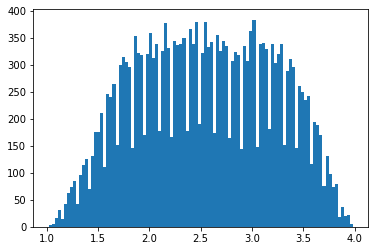

In [11]:
plt.hist(mass_data,bins=100)
plt.show()

In [12]:
proton_flux = mods.HillasGaisser2012('H3a').nucleus_flux(14,Energy)
helium_flux = mods.HillasGaisser2012('H3a').nucleus_flux(402,Energy)
oxygen_flux = mods.HillasGaisser2012('H3a').nucleus_flux(1206,Energy)
iron_flux = mods.HillasGaisser2012('H3a').nucleus_flux(5426,Energy)
lnA_H3A = mods.HillasGaisser2012('H3a').lnA(Energy)
total_flux = mods.HillasGaisser2012('H3a').total_flux(Energy)

In [13]:
H3A = mods.HillasGaisser2012('H3a')

In [14]:
proton_flux1 = mods.HillasGaisser2012('H4a').nucleus_flux(14,Energy)
helium_flux1 = mods.HillasGaisser2012('H4a').nucleus_flux(402,Energy)
oxygen_flux1 = mods.HillasGaisser2012('H4a').nucleus_flux(1206,Energy)
iron_flux1 = mods.HillasGaisser2012('H4a').nucleus_flux(5426,Energy)
lnA_H4A = mods.HillasGaisser2012('H4a').lnA(Energy)
total_flux1 = mods.HillasGaisser2012('H4a').total_flux(Energy)

In [15]:
H4A = mods.HillasGaisser2012('H4a')

In [16]:
proton_flux2 = mods.GaisserStanevTilav('4-gen').nucleus_flux(14,Energy)
helium_flux2 = mods.GaisserStanevTilav('4-gen').nucleus_flux(402,Energy)
oxygen_flux2 = mods.GaisserStanevTilav('4-gen').nucleus_flux(1206,Energy)
iron_flux2 = mods.GaisserStanevTilav('4-gen').nucleus_flux(5426,Energy)
lnA_GST = mods.GaisserStanevTilav('4-gen').lnA(Energy)
total_flux2 = mods.GaisserStanevTilav('4-gen').total_flux(Energy)

In [17]:
GST = mods.GaisserStanevTilav('4-gen')

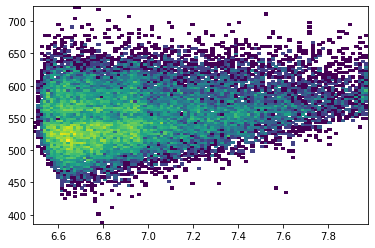

In [18]:
plt.hist2d(energy_data,xmax_data,bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

In [19]:
mean_overall,std_mean,bins,median,ten,ninety = binning(energy_data,xmax_data,20)

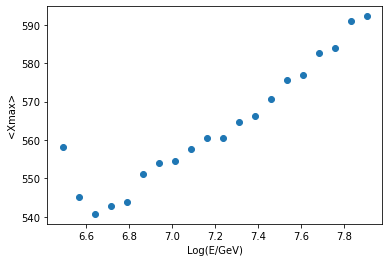

In [20]:
plt.scatter(bins,mean_overall)
plt.xlabel('Log(E/GeV)')
plt.ylabel('<Xmax>')
plt.savefig('Mean_Xmax_plot.png')

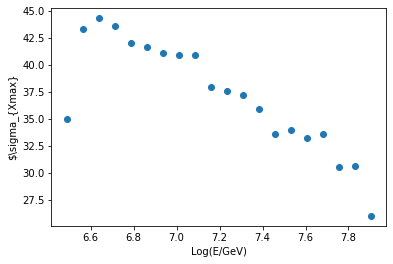

In [21]:
plt.scatter(bins,std_mean)
plt.xlabel('Log(E/GeV)')
plt.ylabel('$\\sigma_{Xmax}')
plt.savefig('sigma_Xmax.png')

In [22]:
files2 = glob.glob('files/kde_plots_*.npy')

In [23]:
energy_stuff = ['6.5 - 6.65', '6.65 - 6.8', '6.8 - 6.95', '6.95 - 7.1', '7.1 - 7.25', '7.25 - 7.4', '7.4 - 7.55', '7.55 - 7.7', '7.7 - 7.85', '7.85 - 8.0']

In [24]:
def kde_model(x,species='proton',energy_range='6.5 - 6.75'):
    kde_models = []
    for i in files2:
        predictions_dict = np.load(i,allow_pickle=True).item()
        if 'mass' in species:
            kde_models.append(scipy.stats.gaussian_kde(predictions_dict[energy_range][species]))
        else:
            #weights = [1/abs(i) for i in predictions_dict[energy_range][species+'_error']]
            kde_models.append(scipy.stats.gaussian_kde(predictions_dict[energy_range][species]))
    output = []
    for i in kde_models:
        output.append(i.evaluate(x))
    return np.array([np.mean(i) for i in list(zip(*output))])

In [25]:
Energy_range = np.linspace(400,800,1000)
mass_range = np.linspace(0,5,1000)

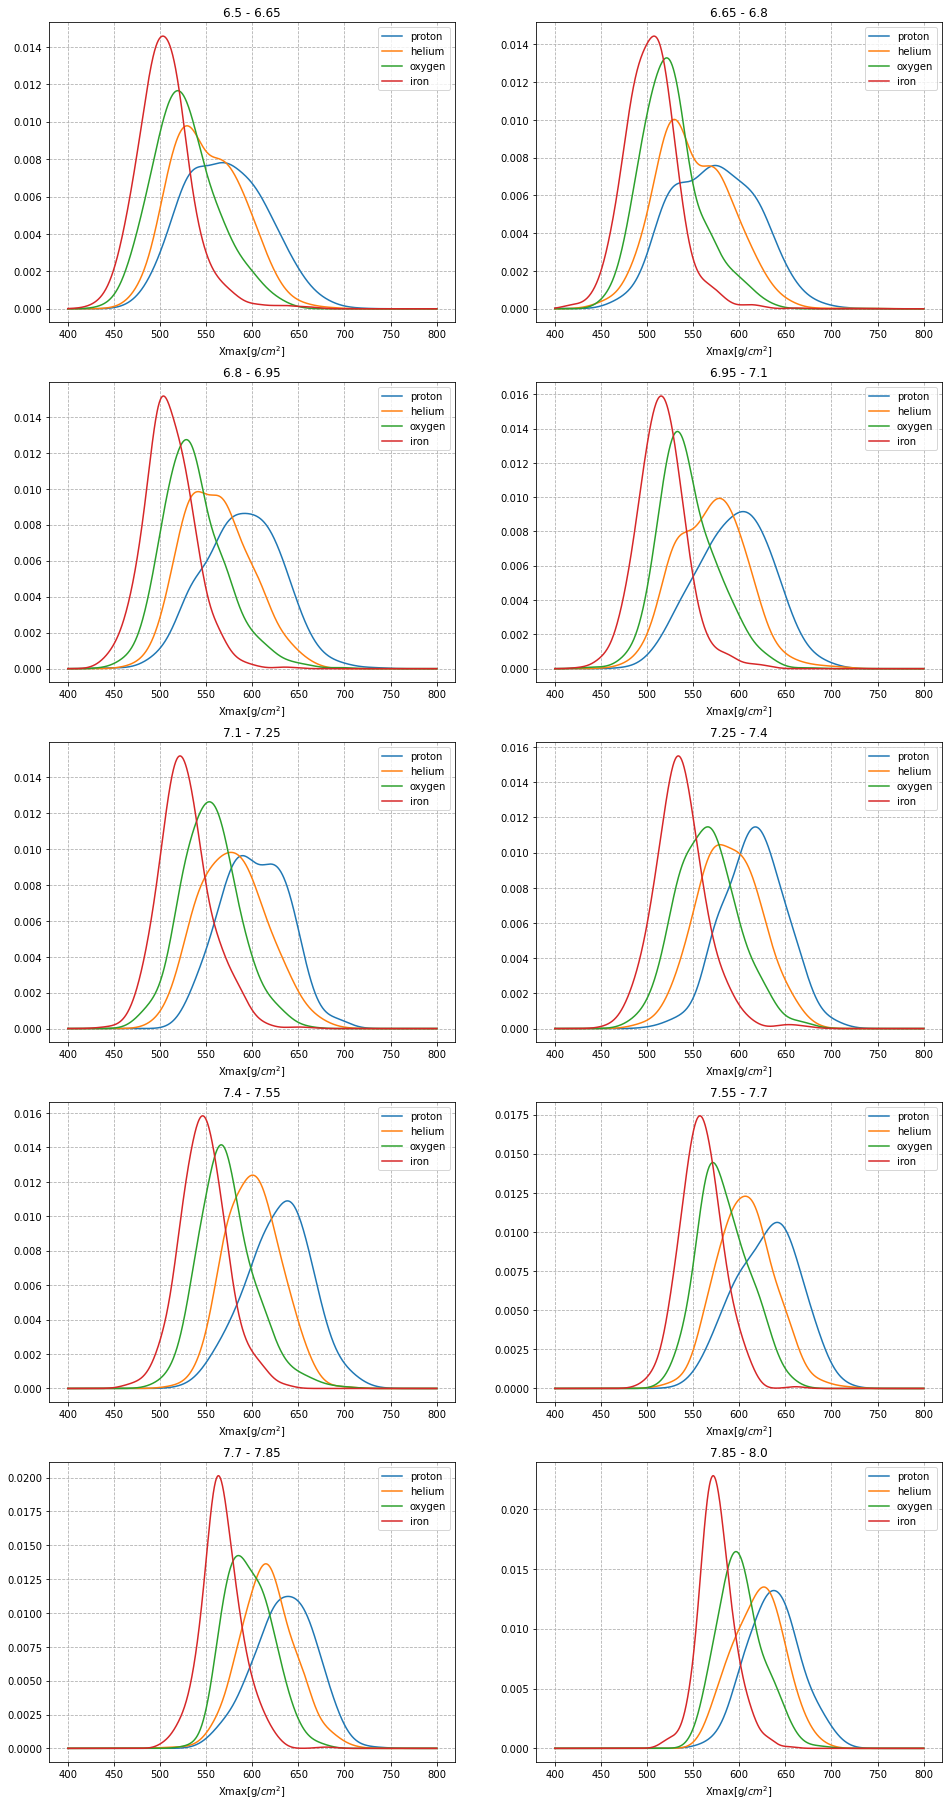

In [26]:
fig,axs = plt.subplots(5,2,figsize=(16,16*2))
count = 0
count2 = 0
for i in energy_stuff:
    kde_plot_proton = kde_model(Energy_range,species='proton',energy_range = i)
    kde_plot_helium = kde_model(Energy_range,species='helium',energy_range = i)
    kde_plot_oxygen = kde_model(Energy_range,species='oxygen',energy_range = i)
    kde_plot_iron = kde_model(Energy_range,species='iron',energy_range = i)
    
    axs[count][count2].plot(Energy_range,kde_plot_proton,label='proton')
    axs[count][count2].plot(Energy_range,kde_plot_helium,label='helium')
    axs[count][count2].plot(Energy_range,kde_plot_oxygen,label='oxygen')
    axs[count][count2].plot(Energy_range,kde_plot_iron,label='iron')
    axs[count][count2].set_title(i)
    axs[count][count2].legend()
    axs[count][count2].grid(True,linestyle='dashed')
    axs[count][count2].set_xlabel('Xmax[g/$cm^2$]')
    
    count2 += 1
    if count2 == 2:
        count2 = 0
        count += 1
plt.savefig('Xmax_kde_plots.png')

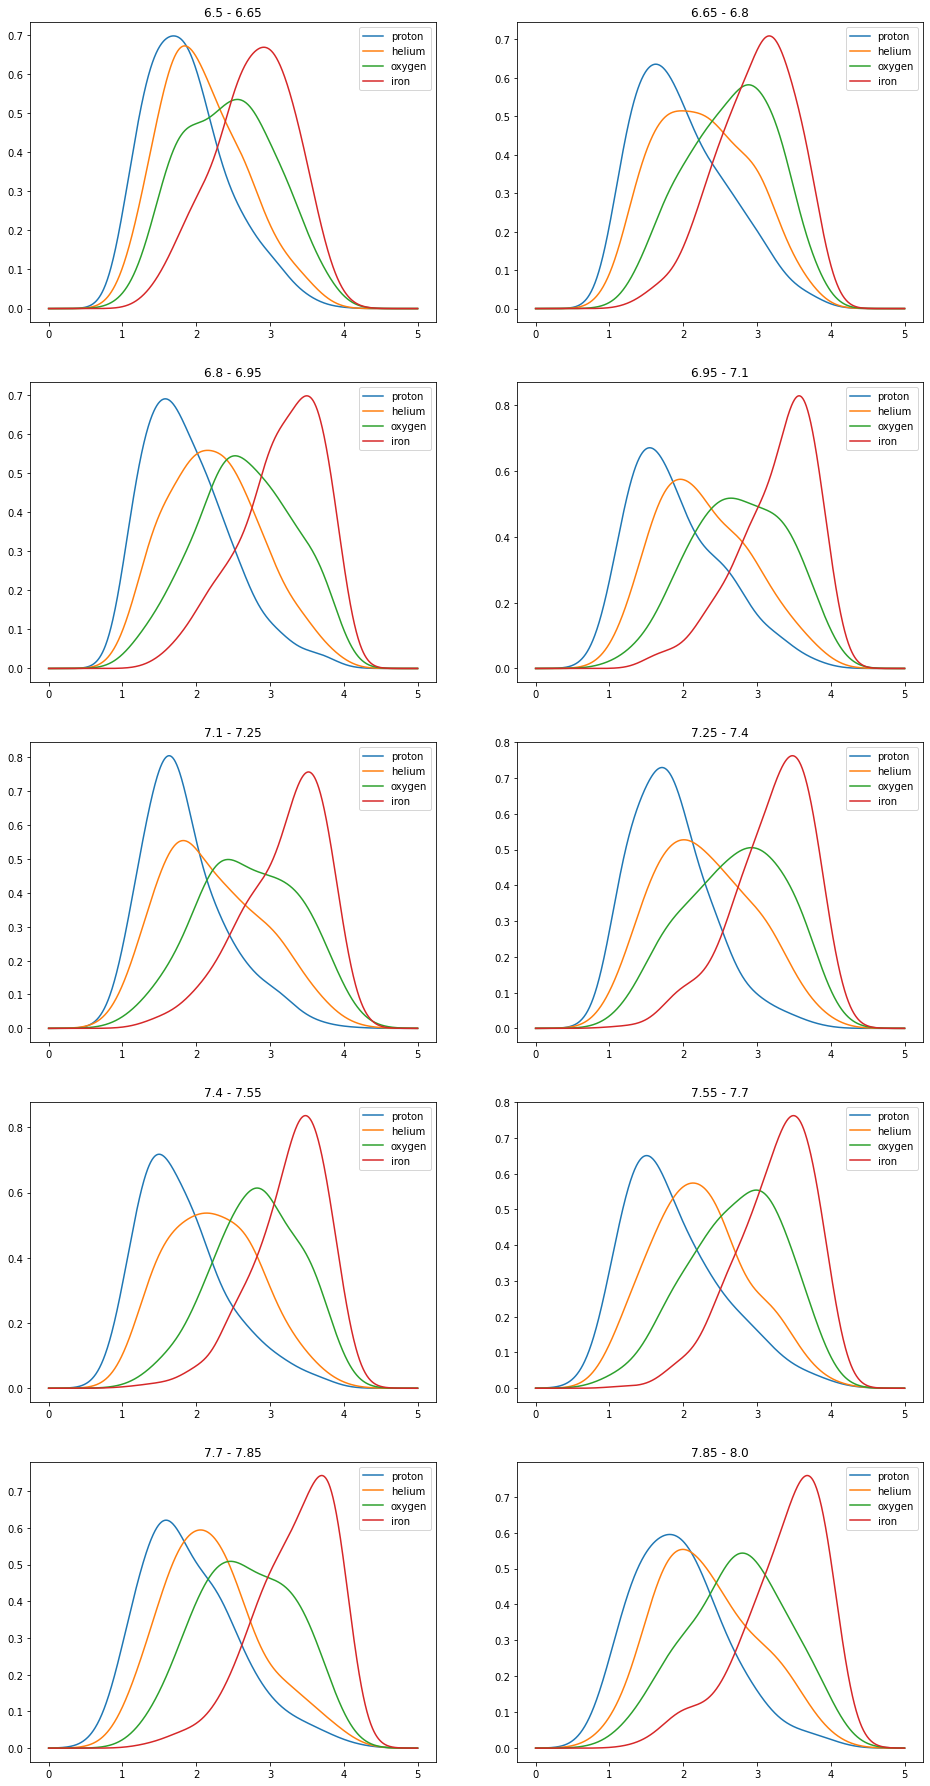

In [27]:
fig,axs = plt.subplots(5,2,figsize=(16,16*2))
count = 0
count2 = 0
for i in energy_stuff:
    kde_plot_proton_mass = kde_model(mass_range,species='proton_mass',energy_range=i)
    kde_plot_helium_mass = kde_model(mass_range,species='helium_mass',energy_range=i)
    kde_plot_oxygen_mass = kde_model(mass_range,species='oxygen_mass',energy_range=i)
    kde_plot_iron_mass = kde_model(mass_range,species='iron_mass',energy_range=i)
    
    axs[count][count2].plot(mass_range,kde_plot_proton_mass,label='proton')
    axs[count][count2].plot(mass_range,kde_plot_helium_mass,label='helium')
    axs[count][count2].plot(mass_range,kde_plot_oxygen_mass,label='oxygen')
    axs[count][count2].plot(mass_range,kde_plot_iron_mass,label='iron')
    axs[count][count2].set_title(i)
    axs[count][count2].legend()
    
    count2 += 1
    if count2 == 2:
        count2 = 0
        count += 1
plt.show()

In [28]:
def xmax_kde(x,a,b,c,d,energy_range='6.5 - 6.75'):
    return a * kde_model(x,species='proton',energy_range=energy_range) + b * kde_model(x,species='helium',energy_range=energy_range) + c * kde_model(x,species= 'oxygen',energy_range=energy_range) + d * kde_model(x,species='iron',energy_range=energy_range)

In [29]:
def mass_kde(x,a,b,c,d,energy_range='6.5 - 6.75'):
    return a * kde_model(x,species='proton_mass',energy_range=energy_range) + b * kde_model(x,species='helium_mass',energy_range=energy_range) + c * kde_model(x,species= 'oxygen_mass',energy_range=energy_range) + d * kde_model(x,species='iron_mass',energy_range=energy_range)

In [30]:
def mse(f_obs,f_exp):
    return np.mean([(i-j)**2 for i,j in zip(f_obs,f_exp)])

In [31]:
def plot_model(model,name,bin_value,plot = False):
    if plot:
        fig,axs = plt.subplots(5,2,figsize=(16,16*2))

    count = 0
    count2 = 0
    
    num_bins = [bin_value]
    
    energy_bin = []
    chi2 = [[]]

    count_new = 0
    
    
    for i in energy_stuff:
        value = i.split('-')
        max_value = float(value[1])
        min_value = float(value[0])
    
        my_function = partial(xmax_kde,energy_range = i)
    
        counts,bins = np.histogram(xmax_data[(energy_data>=min_value)&(energy_data<=max_value)],bins=num_bins[0],density=True)
      
        energy  = 10**np.mean([min_value,max_value])
        
        sum_flux = model.nucleus_flux(14,energy) + model.nucleus_flux(402,energy) + model.nucleus_flux(1206,energy) + model.nucleus_flux(5426,energy)
        proton_frac = model.nucleus_flux(14,energy)/sum_flux
        helium_frac = model.nucleus_flux(402,energy)/sum_flux
        oxygen_frac = model.nucleus_flux(1206,energy)/sum_flux
        iron_frac = model.nucleus_flux(5426,energy)/sum_flux
    
        energy_bin.append(np.mean([min_value,max_value]))
        
        sum_kde = my_function(bins[0:-1],proton_frac,helium_frac,oxygen_frac,iron_frac)
        
        chi2[count_new].append(mse(f_obs = sum_kde[counts>0],f_exp = counts[counts>0]))
        
        if plot:
            axs[count][count2].scatter(bins[0:-1],counts,label='data')
            axs[count][count2].plot(bins[0:-1],my_function(bins[0:-1],proton_frac,helium_frac,oxygen_frac,iron_frac),label='fit')
            axs[count][count2].plot(bins[0:-1],proton_frac* kde_model(bins[0:-1],species='proton',energy_range=i),label='proton')
            axs[count][count2].plot(bins[0:-1],helium_frac* kde_model(bins[0:-1],species='helium',energy_range=i),label='helium')
            axs[count][count2].plot(bins[0:-1],oxygen_frac* kde_model(bins[0:-1],species='oxygen',energy_range=i),label='oxygen')
            axs[count][count2].plot(bins[0:-1],iron_frac* kde_model(bins[0:-1],species='iron',energy_range=i),label='iron')
            axs[count][count2].legend()
            axs[count][count2].set_title('Energy: %s, Proton: %.2f, Helium: %.2f, Oxygen: %.2f, Iron: %.2f'%(i,proton_frac,helium_frac,oxygen_frac,iron_frac))
    
        count2 += 1
        if count2 == 2:
            count2 = 0
            count += 1
    if plot:    
        plt.savefig(name)
    
    return energy_bin,chi2

In [32]:
def get_values(my_list):
    output = [[] for i in range(len(my_list[0][0]))]
    for i in range(len(my_list)):
        for j in range(len(my_list[0][0])):
            output[j].append(my_list[i][0][j])
    return output

In [33]:
from sklearn.utils import resample

In [34]:
def resample_method(input_value):
    mean_value = []
    for i in range(5000):
        new_one = resample(input_value)
        mean_value.append(np.mean(new_one))
    return mean_value

In [35]:
H3A_chi2 = []
for i in range(5,105,5):
    energy_bin,chi2 = plot_model(H3A,'H3A_fit.png',bin_value=i)
    H3A_chi2.append(chi2)

([6.575, 6.725, 6.875, 7.025, 7.175, 7.325, 7.475, 7.625, 7.775, 7.925],
 [[9.998826518307623e-07,
   3.446571170092845e-07,
   5.133096177790561e-07,
   5.768013826098124e-07,
   6.881091595813897e-07,
   1.287095479208015e-06,
   2.012296771288712e-06,
   1.4950786701562977e-06,
   2.825199285486007e-06,
   6.272460216858489e-06]])

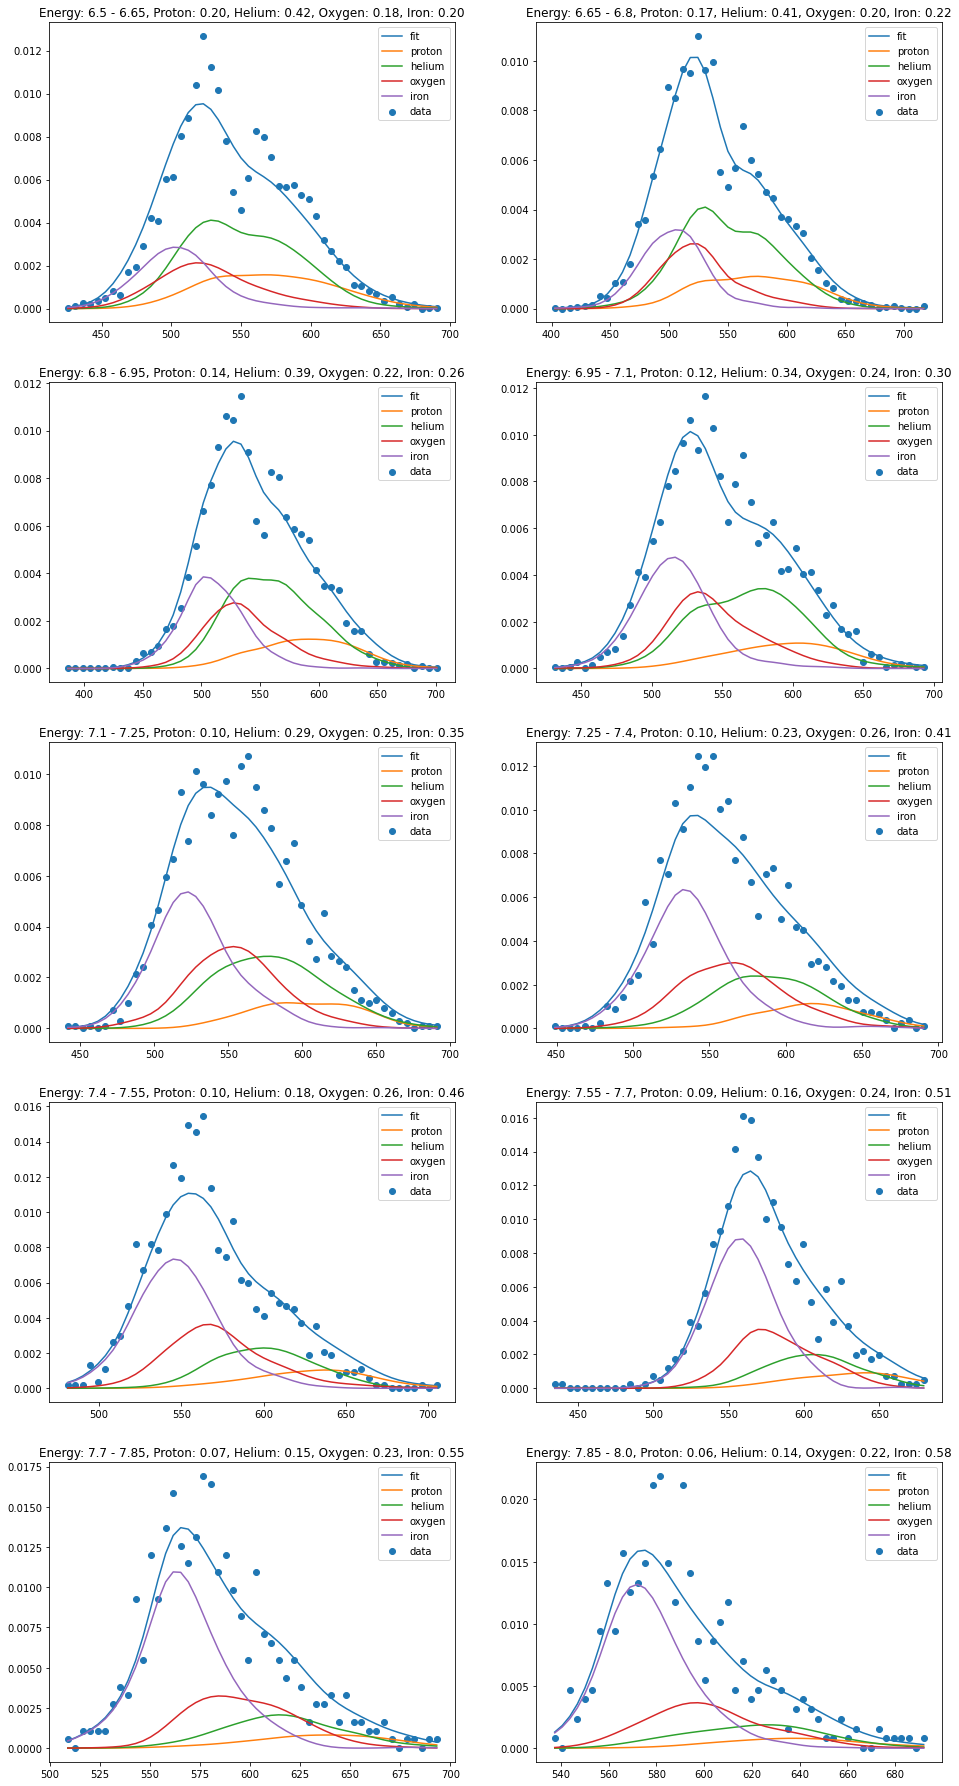

In [36]:
plot_model(H3A,'H3A_fit.png',bin_value=50,plot=True)

In [37]:
H3A_chi2_mean = [np.mean(resample_method(i)) for i in get_values(H3A_chi2)]
H3A_std = [np.std(resample_method(i)) for i,j in zip(get_values(H3A_chi2),H3A_chi2_mean)]

In [38]:
H4A_chi2 = []
for i in range(5,105,5):
    energy_bin,chi2 = plot_model(H4A,'H4A_fit.png',bin_value=i)
    H4A_chi2.append(chi2)

([6.575, 6.725, 6.875, 7.025, 7.175, 7.325, 7.475, 7.625, 7.775, 7.925],
 [[9.799111444452366e-07,
   3.5550716025794007e-07,
   5.371937480511106e-07,
   5.842712355175743e-07,
   7.35923772569786e-07,
   1.5977417785580618e-06,
   2.4638730805562546e-06,
   1.8746399296241298e-06,
   3.3258685404057843e-06,
   7.023711440517617e-06]])

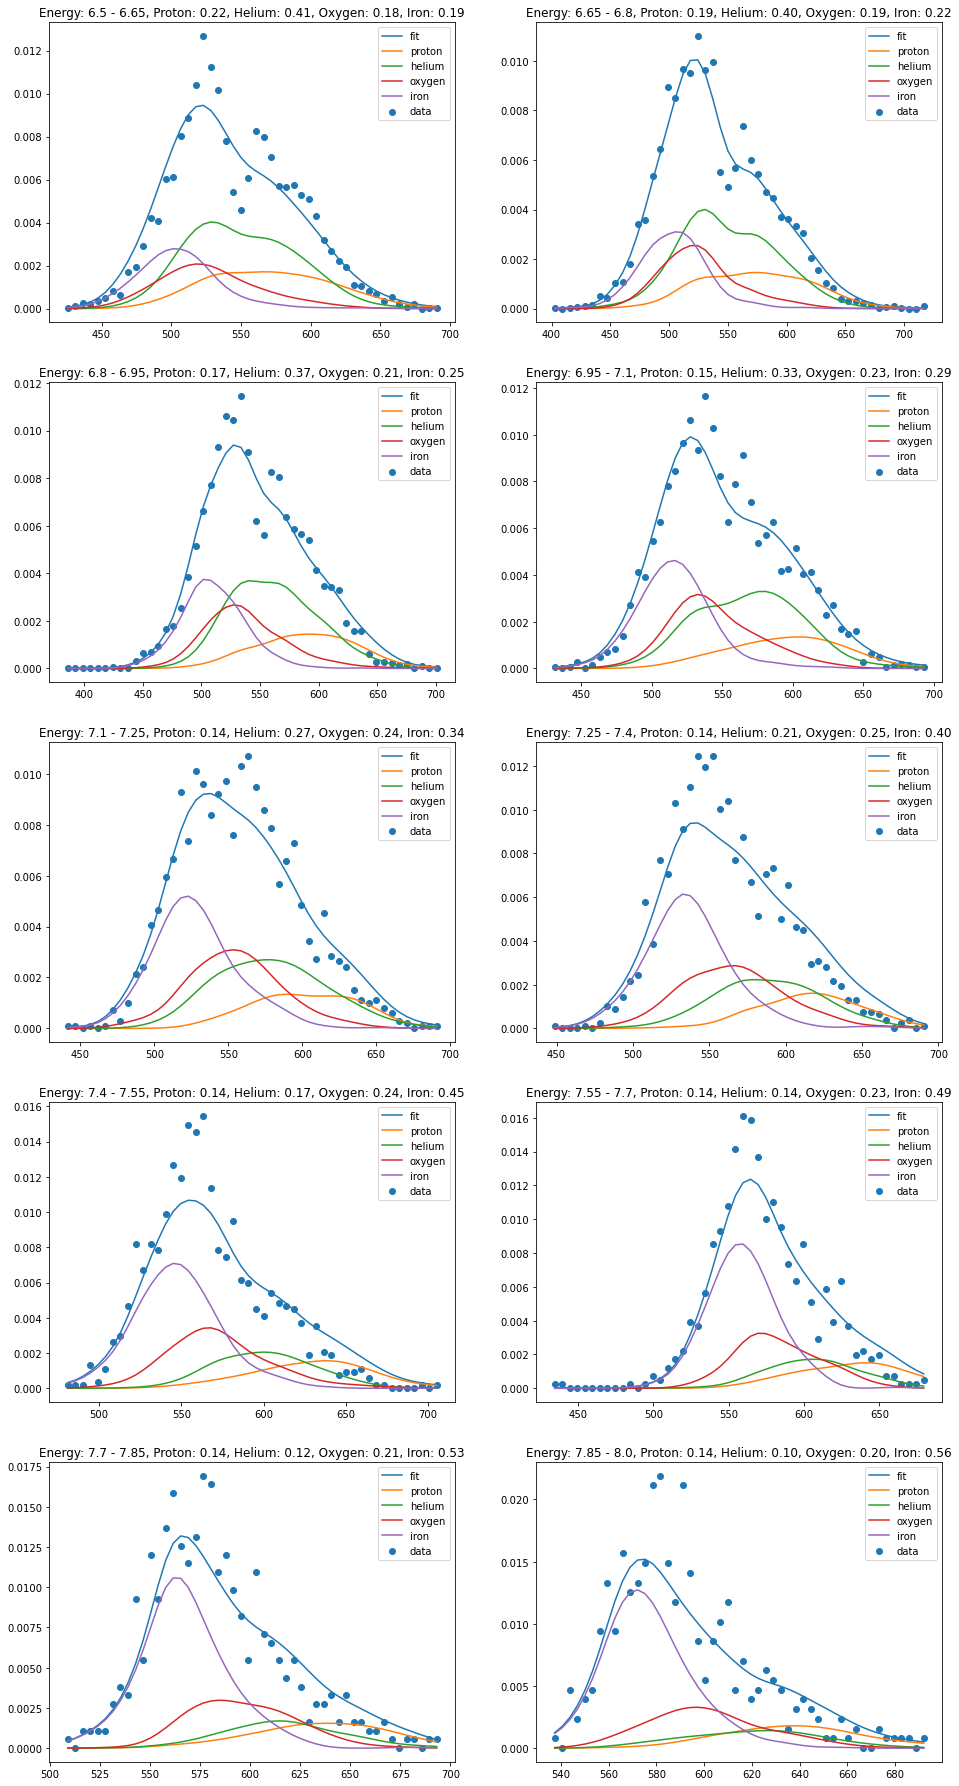

In [39]:
plot_model(H4A,'H4A_fit.png',bin_value=50,plot=True)

In [40]:
H4A_chi2_mean = [np.mean(resample_method(i)) for i in get_values(H4A_chi2)]
H4A_std = [np.std(resample_method(i)) for i,j in zip(get_values(H4A_chi2),H4A_chi2_mean)]

In [41]:
GST_chi2 = []
for i in range(5,105,5):
    energy_bin,chi2 = plot_model(GST,'GST_fit.png',bin_value=i)
    GST_chi2.append(chi2)

([6.575, 6.725, 6.875, 7.025, 7.175, 7.325, 7.475, 7.625, 7.775, 7.925],
 [[1.2934485092301796e-06,
   3.670414946889929e-07,
   5.935105470531638e-07,
   7.716129477344068e-07,
   9.067690134140192e-07,
   1.541596188139535e-06,
   2.1523617708395557e-06,
   1.6926890837780068e-06,
   3.820613770415812e-06,
   8.448496029076574e-06]])

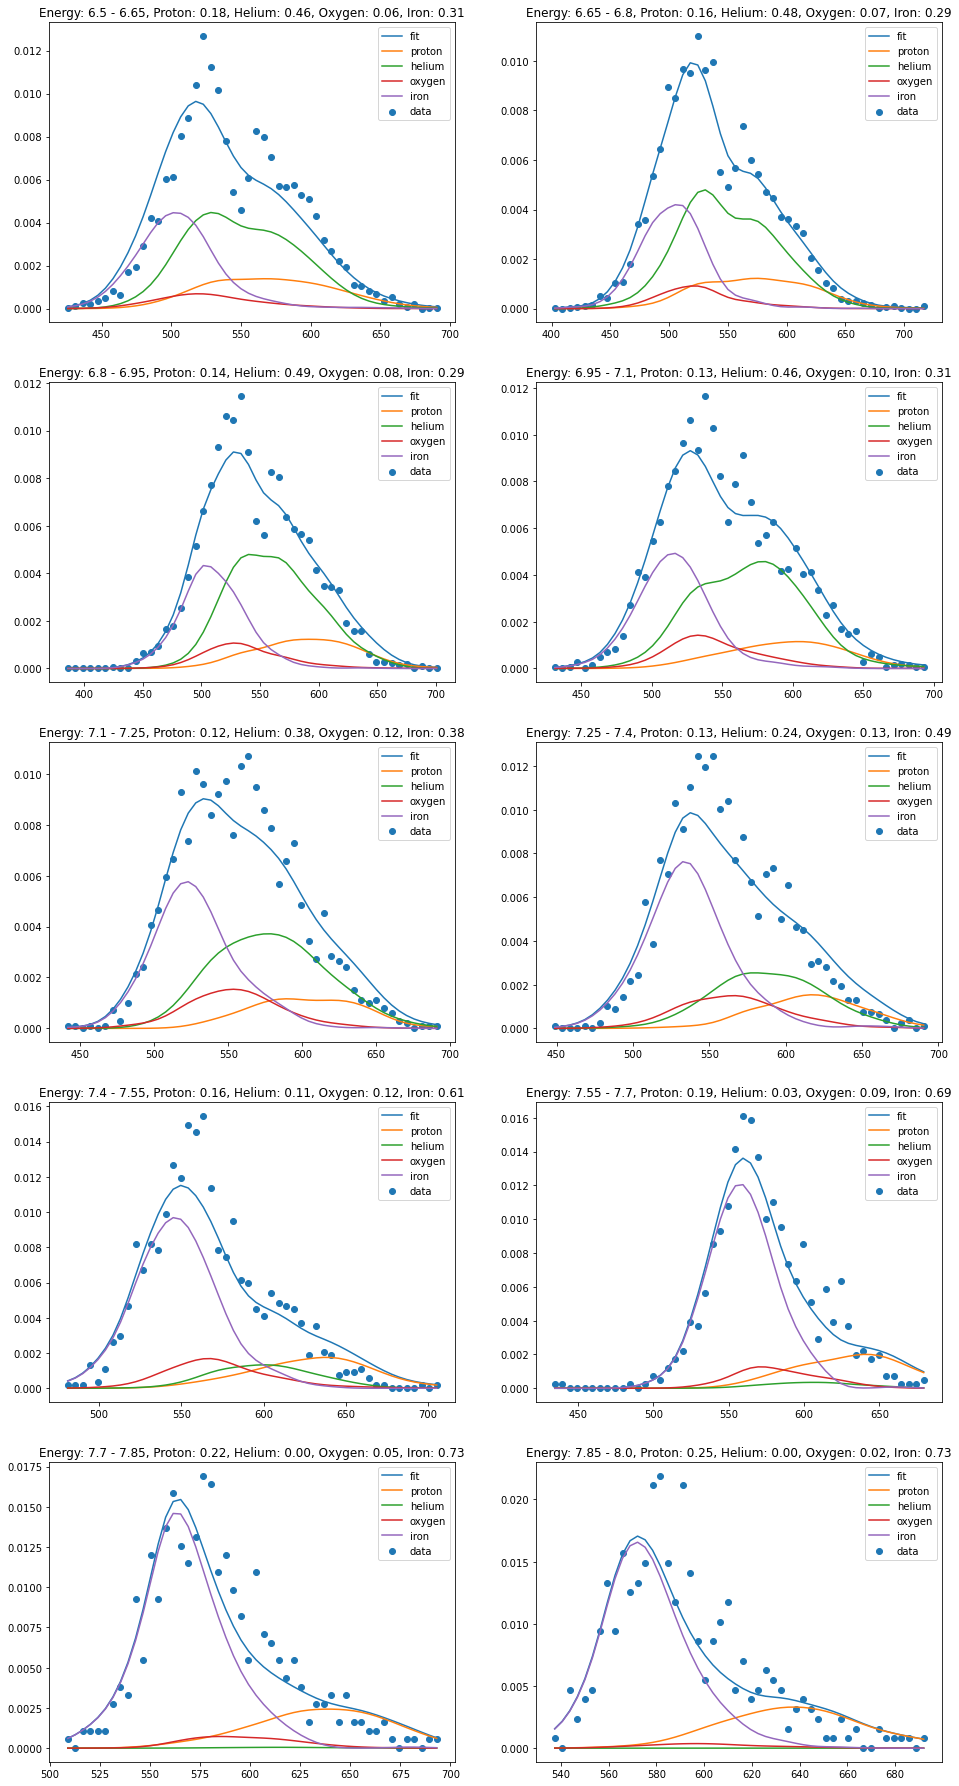

In [42]:
plot_model(GST,'GST_fit.png',bin_value=50,plot=True)

In [43]:
GST_chi2_mean = [np.mean(resample_method(i)) for i in get_values(GST_chi2)]
GST_std = [np.std(resample_method(i)) for i,j in zip(get_values(GST_chi2),GST_chi2_mean)]

In [44]:
G3gen_chi2 = []
for i in range(5,105,5):
    energy_bin,chi2 = plot_model(mods.GaisserStanevTilav('3-gen'),'GH_fit.png',bin_value=i)
    G3gen_chi2.append(chi2)

In [45]:
G3gen_chi2_mean = [np.mean(resample_method(i)) for i in get_values(G3gen_chi2)]
G3gen_std = [np.std(resample_method(i)) for i,j in zip(get_values(G3gen_chi2),G3gen_chi2_mean)]

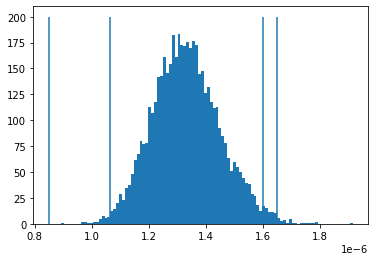

In [46]:
plt.hist(resample_method(get_values(GST_chi2)[0]),bins=100)
plt.vlines(np.mean(get_values(GST_chi2)[0])+np.std(get_values(GST_chi2)[0])/2,0,200)
plt.vlines(np.mean(get_values(GST_chi2)[0])-np.std(get_values(GST_chi2)[0])/2,0,200)
plt.vlines(np.quantile(get_values(GST_chi2)[0],0.16),0,200)
plt.vlines(np.quantile(get_values(GST_chi2)[0],0.84),0,200)
plt.show()

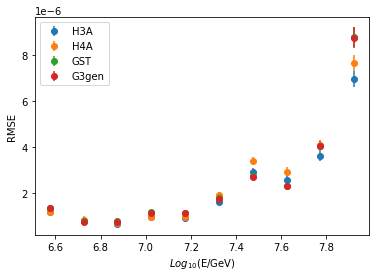

In [47]:
plt.errorbar(energy_bin,H3A_chi2_mean,yerr =  np.array(H3A_std)/2,label='H3A',fmt='o')
plt.errorbar(energy_bin,H4A_chi2_mean,yerr = np.array(H4A_std)/2,label='H4A',fmt='o')
plt.errorbar(energy_bin,GST_chi2_mean,yerr = np.array(GST_std)/2,label='GST',fmt='o')
plt.errorbar(energy_bin,G3gen_chi2_mean,yerr = np.array(G3gen_std)/2,label='G3gen',fmt='o')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('$Log_{10}$(E/GeV)')
plt.savefig('Model_fit_comparison.png')

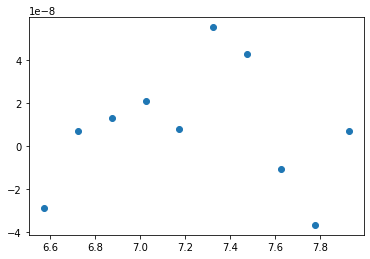

In [48]:
plt.scatter(energy_bin,[i-j for i,j in zip(GST_chi2_mean,G3gen_chi2_mean)])
plt.show()

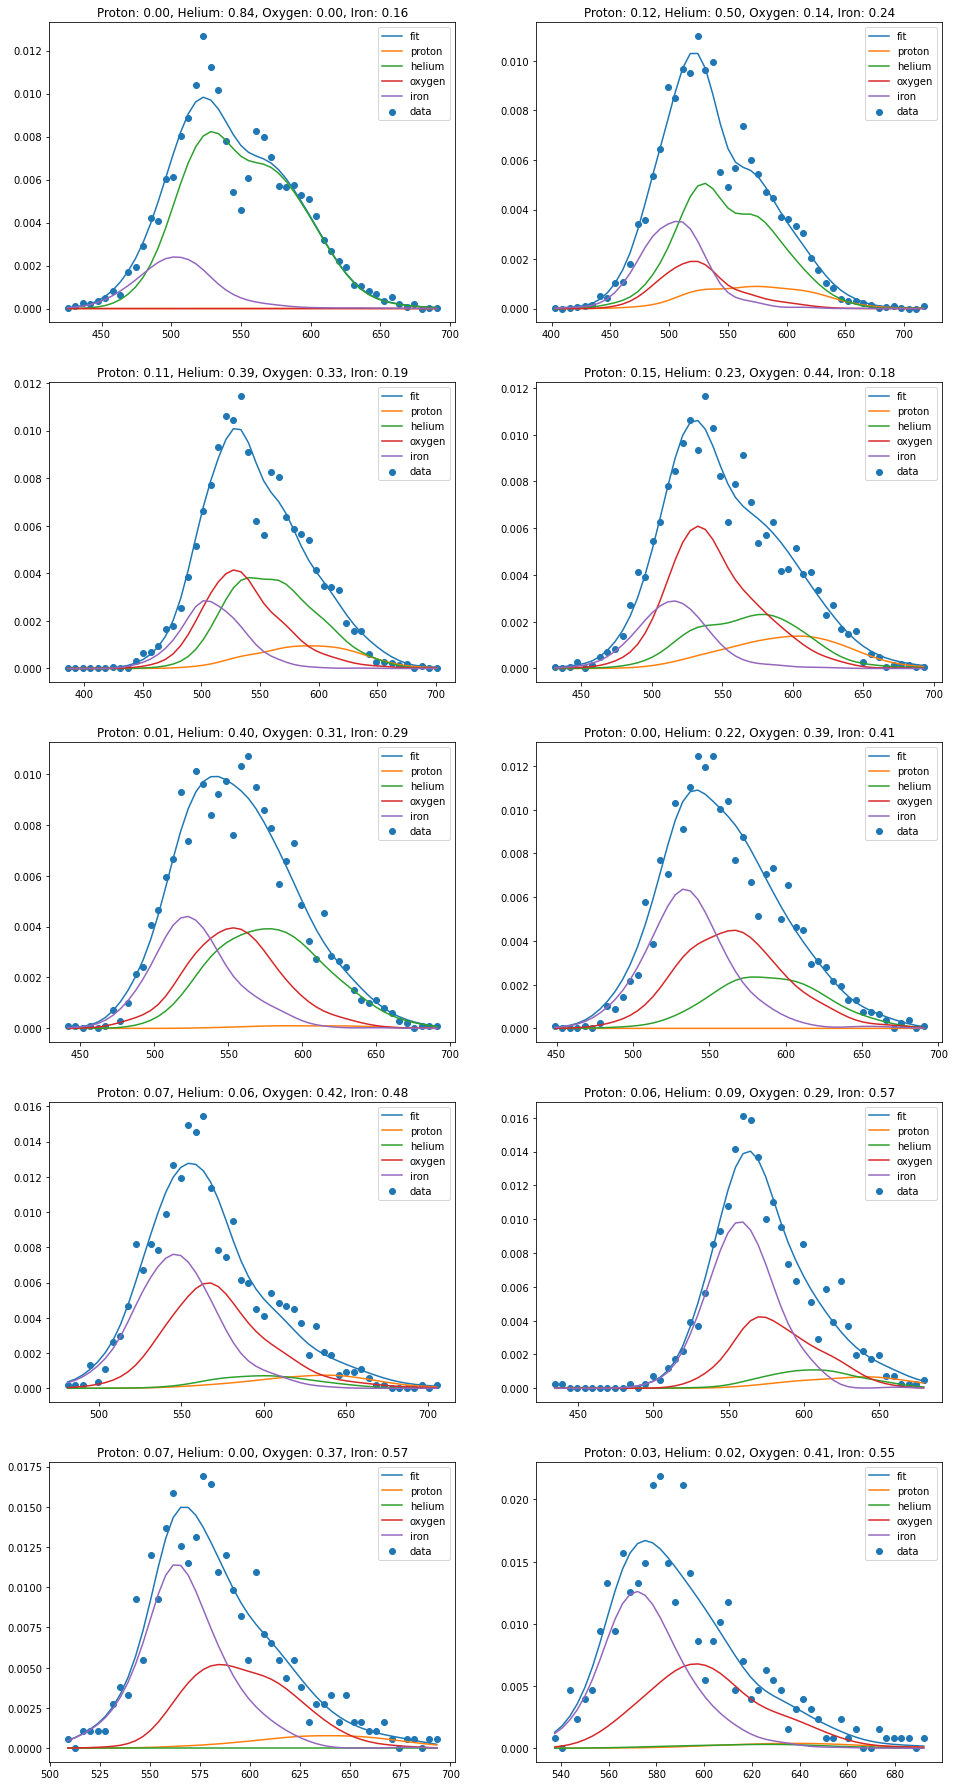

In [49]:
fig,axs = plt.subplots(5,2,figsize=(16,16*2))
#fit2,axs2 = plt.subplots(3,2,figsize=(11,11))
count = 0
count2 = 0

#num_bins = list(range(5,55,5))
num_bins = [10,25,50]

proton_frac = [[] for i in range(len(num_bins))]
proton_std = [[] for i in range(len(num_bins))]

helium_frac = [[] for i in range(len(num_bins))]
helium_std = [[] for i in range(len(num_bins))]

oxygen_frac = [[] for i in range(len(num_bins))]
oxygen_std = [[] for i in range(len(num_bins))]

iron_frac = [[] for i in range(len(num_bins))]
iron_std = [[] for i in range(len(num_bins))]

lnA = [[] for i in range(len(num_bins))]

energy_bin1 = []

for i in energy_stuff:
    value = i.split('-')
    max_value = float(value[1])
    min_value = float(value[0])
    
    my_function = partial(xmax_kde,energy_range = i)
    #my_function2 = partial(mass_kde,energy_range=i)
    
    count_bin = 0
    for bin_value in num_bins:
        counts,bins = np.histogram(xmax_data[(energy_data>=min_value)&(energy_data<=max_value)],bins=bin_value,density=True)
        #counts2,bins2 = np.histogram(mass_data[(energy_data>=min_value)&(energy_data<=max_value)],bins=31,density=True)
    
        energy  = 10**np.mean([min_value,max_value])
        
        proton_init = GST.nucleus_flux(14,energy)/GST.total_flux(energy)
        helium_init = GST.nucleus_flux(402,energy)/GST.total_flux(energy)
        oxygen_init = GST.nucleus_flux(1206,energy)/GST.total_flux(energy)
        iron_init = GST.nucleus_flux(5426,energy)/GST.total_flux(energy)
        
        fit = curve_fit(my_function,bins[0:-1],counts,bounds=(0,1),p0=[proton_init,helium_init,oxygen_init,iron_init])
    
        #fit2 = curve_fit(my_function2,bins2[0:-1],counts2,bounds=(0,1))
    
        proton_frac[count_bin].append(fit[0][0])
        proton_std[count_bin].append(fit[1][0][0]**0.5)
    
        helium_frac[count_bin].append(fit[0][1])
        helium_std[count_bin].append(fit[1][1][1]**0.5)
    
        oxygen_frac[count_bin].append(fit[0][2])
        oxygen_std[count_bin].append(fit[1][2][2]**0.5)
    
        iron_frac[count_bin].append(fit[0][3])
        iron_std[count_bin].append(fit[1][3][3]**0.5)
        
        lnA[count_bin].append(1*fit[0][0] + 2 * fit[0][1] +3 * fit[0][2] + 4 * fit[0][3])
        
        count_bin += 1
    
    energy_bin1.append(np.mean([min_value,max_value]))
    
    axs[count][count2].scatter(bins[0:-1],counts,label='data')
    axs[count][count2].plot(bins[0:-1],my_function(bins[0:-1],fit[0][0],fit[0][1],fit[0][2],fit[0][3]),label='fit')
    axs[count][count2].plot(bins[0:-1],fit[0][0]* kde_model(bins[0:-1],species='proton',energy_range=i),label='proton')
    axs[count][count2].plot(bins[0:-1],fit[0][1]* kde_model(bins[0:-1],species='helium',energy_range=i),label='helium')
    axs[count][count2].plot(bins[0:-1],fit[0][2]* kde_model(bins[0:-1],species='oxygen',energy_range=i),label='oxygen')
    axs[count][count2].plot(bins[0:-1],fit[0][3]* kde_model(bins[0:-1],species='iron',energy_range=i),label='iron')
    axs[count][count2].legend()
    axs[count][count2].set_title('Proton: %.2f, Helium: %.2f, Oxygen: %.2f, Iron: %.2f'%(fit[0][0],fit[0][1],fit[0][2],fit[0][3]))
    
    #axs2[count][count2].scatter(bins2[0:-1],counts2)
    #axs2[count][count2].plot(bins2[0:-1],my_function2(bins2[0:-1],fit[0][0],fit[0][1],fit[0][2],fit[0][3]))
      
    count2 += 1
    if count2 == 2:
        count2 = 0
        count += 1
plt.savefig('KDE_fit.png')

In [50]:
def output(frac,std):
    x1 = list(zip(*frac))
    x2 = list(zip(*std))
    value_update = []
    for i in range(len(x1)):
        value = 0
        value2 = 0
        for j in range(len(x1[i])):
            value += x1[i][j]/x2[i][j]
            value2 += 1/x2[i][j]
        value_update.append(value/value2)
    return value_update

def std_output(std):
    x1 = list(zip(*std))
    value_update = []
    for i in range(len(x1)):
        value = 0
        for j in range(len(x1[i])):
            value += 1/x1[i][j]**2
        value_update.append((len(x1[i])/value)**0.5)
    return value_update

In [51]:
proton_frac_mean = output(proton_frac,proton_std)
helium_frac_mean = output(helium_frac,helium_std)
oxygen_frac_mean = output(oxygen_frac,oxygen_std)
iron_frac_mean = output(iron_frac,iron_std)

proton_frac_std = std_output(proton_std)
helium_frac_std = std_output(helium_std)
oxygen_frac_std = std_output(oxygen_std)
iron_frac_std = std_output(iron_std)

lnA_mean = [np.mean(i) for i in list(zip(*lnA))]

In [52]:
'''
proton_frac_mean = [np.mean(i) for i in list(zip(*proton_frac))]
proton_frac_ten = [np.quantile(i,0.1) for i in list(zip(*proton_frac))]
proton_frac_ninety = [np.quantile(i,0.9) for i in list(zip(*proton_frac))]

helium_frac_mean = [np.mean(i) for i in list(zip(*helium_frac))]
helium_frac_ten = [np.quantile(i,0.1) for i in list(zip(*helium_frac))]
helium_frac_ninety = [np.quantile(i,0.9) for i in list(zip(*helium_frac))]

oxygen_frac_mean = [np.mean(i) for i in list(zip(*oxygen_frac))]
oxygen_frac_ten = [np.quantile(i,0.1) for i in list(zip(*oxygen_frac))]
oxygen_frac_ninety = [np.quantile(i,0.9) for i in list(zip(*oxygen_frac))]

iron_frac_mean = [np.mean(i) for i in list(zip(*iron_frac))]
iron_frac_ten = [np.quantile(i,0.1) for i in list(zip(*iron_frac))]
iron_frac_ninety = [np.quantile(i,0.9) for i in list(zip(*iron_frac))]

lnA_mean = [np.mean(i) for i in list(zip(*lnA))]
lnA_ten = [np.quantile(i,0.1) for i in list(zip(*lnA))]
lnA_ninety = [np.quantile(i,0.9) for i in list(zip(*lnA))]
'''

'\nproton_frac_mean = [np.mean(i) for i in list(zip(*proton_frac))]\nproton_frac_ten = [np.quantile(i,0.1) for i in list(zip(*proton_frac))]\nproton_frac_ninety = [np.quantile(i,0.9) for i in list(zip(*proton_frac))]\n\nhelium_frac_mean = [np.mean(i) for i in list(zip(*helium_frac))]\nhelium_frac_ten = [np.quantile(i,0.1) for i in list(zip(*helium_frac))]\nhelium_frac_ninety = [np.quantile(i,0.9) for i in list(zip(*helium_frac))]\n\noxygen_frac_mean = [np.mean(i) for i in list(zip(*oxygen_frac))]\noxygen_frac_ten = [np.quantile(i,0.1) for i in list(zip(*oxygen_frac))]\noxygen_frac_ninety = [np.quantile(i,0.9) for i in list(zip(*oxygen_frac))]\n\niron_frac_mean = [np.mean(i) for i in list(zip(*iron_frac))]\niron_frac_ten = [np.quantile(i,0.1) for i in list(zip(*iron_frac))]\niron_frac_ninety = [np.quantile(i,0.9) for i in list(zip(*iron_frac))]\n\nlnA_mean = [np.mean(i) for i in list(zip(*lnA))]\nlnA_ten = [np.quantile(i,0.1) for i in list(zip(*lnA))]\nlnA_ninety = [np.quantile(i,0.9) f

In [54]:
icecube = np.genfromtxt('files/composition.csv',delimiter=',')
hydrogen_icecube = np.genfromtxt('files/hydrogen.csv',delimiter=',')
iron_icecube = np.genfromtxt('files/iron.csv',delimiter=',')
helium_icecube = np.genfromtxt('files/helium.csv',delimiter=',')
oxygen_icecube = np.genfromtxt('files/oxygen.csv',delimiter=',')

In [55]:
print(total_flux)

[1.17874427e-13 1.16844818e-13 1.15827093e-13 ... 3.47703963e-18
 3.47600736e-18 3.47497549e-18]


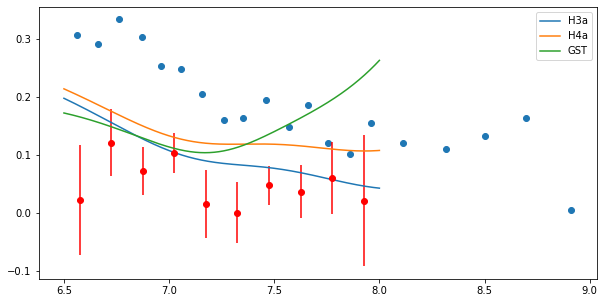

In [56]:
plt.figure(figsize=(10,5))
plt.errorbar(energy_bin1,proton_frac_mean,fmt='o',color='r',yerr=np.array(proton_frac_std)/2)
#plt.errorbar(energy_bin,proton_frac_ten,fmt='--',color='r')
#plt.errorbar(energy_bin,proton_frac_ninety,fmt='--',color='r')
plt.plot(np.log10(Energy),proton_flux/total_flux,label='H3a')
plt.plot(np.log10(Energy),proton_flux1/total_flux1,label='H4a')
plt.plot(np.log10(Energy),proton_flux2/total_flux2,label='GST')
plt.scatter(list(zip(*hydrogen_icecube))[0],list(zip(*hydrogen_icecube))[1])
plt.legend()
plt.savefig('proton_result.png')

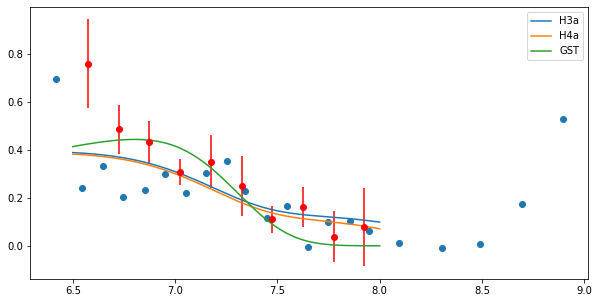

In [57]:
plt.figure(figsize=(10,5))
plt.errorbar(energy_bin1,helium_frac_mean,fmt='o',color='r',yerr=np.array(helium_frac_std)/2)
#plt.errorbar(energy_bin,helium_frac_ten,fmt='--',color='r')
#plt.errorbar(energy_bin,helium_frac_ninety,fmt='--',color='r')
plt.plot(np.log10(Energy),helium_flux/total_flux,label='H3a')
plt.plot(np.log10(Energy),helium_flux1/total_flux1,label='H4a')
plt.plot(np.log10(Energy),helium_flux2/total_flux2,label='GST')
plt.scatter(list(zip(*helium_icecube))[0],list(zip(*helium_icecube))[1])
plt.legend()
plt.savefig('helium_result.png')

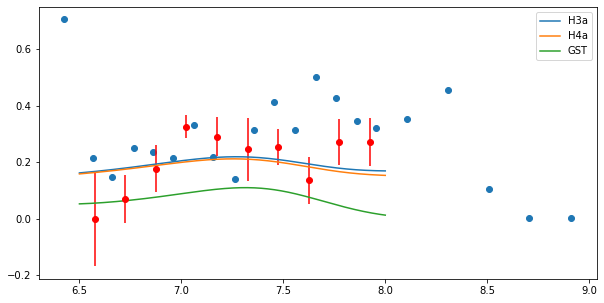

In [58]:
plt.figure(figsize=(10,5))
plt.errorbar(energy_bin1,oxygen_frac_mean,fmt='o',color='r',yerr=np.array(oxygen_frac_std)/2)
#plt.errorbar(energy_bin,oxygen_frac_ten,fmt='--',color='r')
#plt.errorbar(energy_bin,oxygen_frac_ninety,fmt='--',color='r')
plt.plot(np.log10(Energy),oxygen_flux/total_flux,label='H3a')
plt.plot(np.log10(Energy),oxygen_flux1/total_flux1,label='H4a')
plt.plot(np.log10(Energy),oxygen_flux2/total_flux2,label='GST')
plt.scatter(list(zip(*oxygen_icecube))[0],list(zip(*oxygen_icecube))[1])
plt.legend()
plt.savefig('oxygen_result.png')

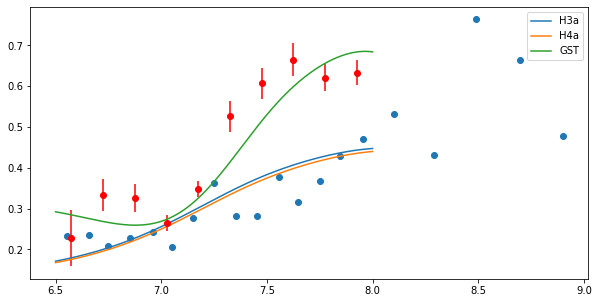

In [59]:
plt.figure(figsize=(10,5))
plt.errorbar(energy_bin1,iron_frac_mean,fmt='o',color='r',yerr=np.array(iron_frac_std)/2)
#plt.errorbar(energy_bin,iron_frac_ten,fmt='--',color='r')
#plt.errorbar(energy_bin,iron_frac_ninety,fmt='--',color='r')
plt.plot(np.log10(Energy),iron_flux/total_flux,label='H3a')
plt.plot(np.log10(Energy),iron_flux1/total_flux1,label='H4a')
plt.plot(np.log10(Energy),iron_flux2/total_flux2,label='GST')
plt.scatter(list(zip(*iron_icecube))[0],list(zip(*iron_icecube))[1])
plt.legend()
plt.savefig('iron_result.png')

In [60]:
lnA_std = [((1*i)**2 + (2*j)**2 + (3*k)**2 + (4*l)**2)**0.5 for i,j,k,l in zip(proton_frac_std,helium_frac_std,oxygen_frac_std,iron_frac_std)]

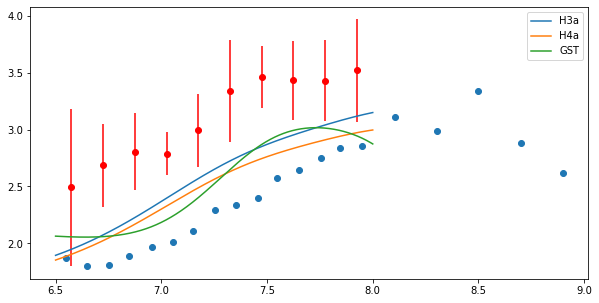

In [61]:
plt.figure(figsize=(10,5))
plt.errorbar(energy_bin1,lnA_mean,fmt='o',color='r',yerr=np.array(lnA_std)/2)
#plt.errorbar(energy_bin,lnA_ten,fmt='--',color='r')
#plt.errorbar(energy_bin,lnA_ninety,fmt='--',color='r')
plt.plot(np.log10(Energy),lnA_H3A,label='H3a')
plt.plot(np.log10(Energy),lnA_H4A,label='H4a')
plt.plot(np.log10(Energy),lnA_GST,label='GST')
plt.scatter(list(zip(*icecube))[0],list(zip(*icecube))[1])
plt.legend()
plt.savefig('lnA_result.png')

In [62]:
[i+j+k+l for i,j,k,l in zip(proton_frac_mean,helium_frac_mean,oxygen_frac_mean,iron_frac_mean)]

[1.0078309699809602,
 1.010051136940974,
 1.0091389170961897,
 1.0015540811229333,
 1.0024486447401533,
 1.0209719757291433,
 1.0174233766478185,
 1.0012225221572582,
 0.9908330211136598,
 1.0034082848633634]

In [66]:
iron = pd.read_csv('files/Iron.csv')
proton = pd.read_csv('files/Proton.csv')
helium = pd.read_csv('files/Helium.csv')
oxygen = pd.read_csv('files/Oxygen.csv')

In [67]:
iron = new_df(iron,4)
proton = new_df(proton,1)
helium = new_df(helium,2)
oxygen = new_df(oxygen,3)

/home/andy/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/andy/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/andy/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/andy/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [68]:
df = iron.append(proton)
df = df.append(helium)
df = df.append(oxygen)

In [69]:
xmax_predictions = xmax_model(df)

In [70]:
xmax_true = df['Xmax'].values

In [71]:
energy_true = df['log_energy'].values

In [72]:
error = [(i-j)**2 for i,j in zip(xmax_predictions,xmax_true)]

In [73]:
mean_overall,std_mean,bins,median,ten,ninety = binning(xmax_true,error,bins=20)

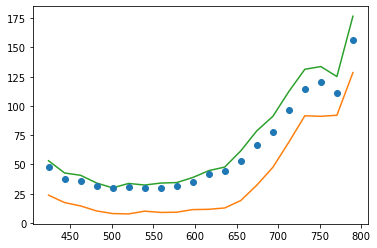

In [74]:
plt.errorbar(bins,mean_overall**0.5,fmt='o')
plt.plot(bins,np.array(ten)**0.5)
plt.plot(bins,np.array(ninety)**0.5)
plt.show()

In [75]:
import matplotlib

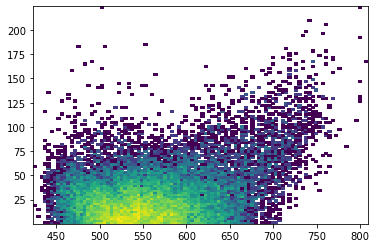

In [76]:
plt.hist2d(xmax_true,np.array(error)**0.5,bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

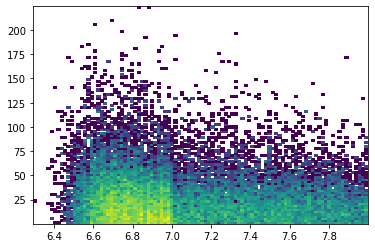

In [77]:
plt.hist2d(energy_true,np.array(error)**0.5,bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

In [78]:
mean_overall,std_mean,bins,median,ten,ninety = binning(energy_true,error,bins=20)

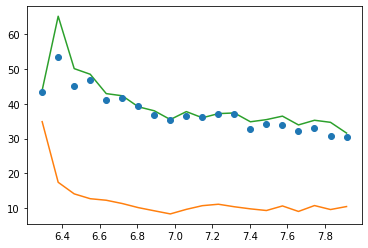

In [79]:
plt.errorbar(bins,mean_overall**0.5,fmt='o')
plt.plot(bins,np.array(ten)**0.5)
plt.plot(bins,np.array(ninety)**0.5)
plt.show()